# Navigation

---

### 1. Start the Environment


The environment is already saved in the Workspace and can be accessed at the file path provided below.  Please run the next code cell without making any changes.

In [1]:
from mlagents.envs import UnityEnvironment
import numpy as np
import torch
import matplotlib.pyplot as plt
from pympler import summary
from pympler import muppy


# env_name = 'maze_architecture_win'
# env_name = 'aug_22_vcs'
# env_name = 'sep_1_vcs'
# env_name = 'sep_1_banana'
env_name = 'sep_28'

# please do not modify the line below
# env = UnityEnvironment(file_name="Banana")
env = UnityEnvironment(file_name="C:/data/ml-agents/scripts/envs/%s/Unity Environment.exe" % env_name, worker_id=0, seed=1)

INFO:mlagents.envs:
'StationAcademy' started successfully!
Unity Academy name: StationAcademy
        Number of Brains: 1
        Number of Training Brains : 1
        Reset Parameters :
		
Unity brain name: DRLBrain
        Number of Visual Observations (per agent): 2
        Vector Observation space size (per agent): 3
        Number of stacked Vector Observation: 3
        Vector Action space type: discrete
        Vector Action space size (per agent): [2, 2]
        Vector Action descriptions: , 


Environments contain **_brains_** which are responsible for deciding the actions of their associated agents. Here we check for the first brain available, and set it as the default brain we will be controlling from Python.

In [2]:
# get the default brain
brain_name = env.brain_names[0]
brain = env.brains[brain_name]
brain_name, brain

('DRLBrain', <mlagents.envs.brain.BrainParameters at 0x1bf2d596b38>)

In [3]:
int(1e5)

100000

### 2. Examine the State and Action Spaces

Run the code cell below to print some information about the environment.

In [4]:
# reset the environment
env_info = env.reset(train_mode=True)[brain_name]

In [5]:
# number of agents in the environment
# print('Number of agents:', len(env_info.agents))

# number of actions
action_size = brain.vector_action_space_size
print('Number of actions:', action_size)

# examine the state space 
state = env_info.vector_observations[0]
print('States look like:', state)
state_size = len(state)
print('States have length:', state_size)

Number of actions: [2, 2]
States look like: [   0.    0.    0.    0.    0.    0. -336.    4.   46.]
States have length: 9


### See initial image

(300, 300, 3)

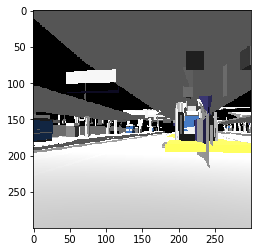

In [6]:
img = np.asarray(env_info.visual_observations)
imgplt = plt.imshow(img[0][0])
height, width, channel = img[0][0].shape
height, width, channel

In [7]:
import torch
import time
import cv2
import PIL

from collections import deque
from agent import Agent
%matplotlib inline

model_weight_name = 'checkpoint.pth'
agent = Agent(state_size=300, action_size=9, seed=0)

In [8]:
# action = 8
# state = np.transpose(np.asarray(env_info.visual_observations)[0][0], (2, 0, 1))
# action_transformed = get_action(action)
# print(action_transformed)

# reward = env_info.rewards[0]
# done = env_info.local_done[0]

# env_info = env.step(action_transformed)[brain_name]
# next_state = np.transpose(np.asarray(env_info.visual_observations)[0][0], (2, 0, 1))
# agent.step(state, action, reward, next_state, done)

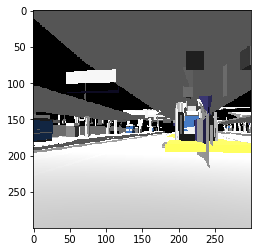

In [9]:
img = np.asarray(env_info.visual_observations)
imgplt = plt.imshow(img[0][0])


### 3. DQN Agent Training

In [10]:
def get_action(action):
    move_forward  = action // 3
    rotate = action % 3
    return [move_forward, rotate]

In [11]:
from sys import stdout
from pympler.tracker import SummaryTracker

def dqn(env_info, n_episodes=1, max_t=2000, eps_start=1.0, eps_end=0.01, 
        eps_decay=0.995, target_scores=1.0, video_flag=True):
    """Deep Q-Learning.
    
    Params
    ======
        n_episodes (int): maximum number of training episodes
        max_t (int): maximum number of timesteps per episode
        eps_start (float): starting value of epsilon, for epsilon-greedy action selection
        eps_end (float): minimum value of epsilon
        eps_decay (float): multiplicative factor (per episode) for decreasing epsilon
        target_scores (float): average scores aming to achieve, the agent will stop training once it reaches this scores
        video_flag (boolean): a flag for whether to record video, if set to True, video would be recorded for every 20 episodes
    
    Returns
    ======
        scores in 2-d array
        positions in 2-d array
    
    """
    
    start = time.time()                       # Start time
    scores = []                               # list containing scores from each episode
    positions = []                            # position list
    scores_window = deque(maxlen=100)         # last 100 scores
    eps = eps_start                           # initialize epsilon
    width, height, channel = [300, 300, 3]
    
    for i_episode in range(1, n_episodes+1):
        
        video_flag = (i_episode % 20 == 1)
        
        # start video recording 
        if video_flag:
            fourcc = cv2.VideoWriter_fourcc('M','S','V','C') #Microspoft Video 1
            video  = cv2.VideoWriter('output_sep_18_%s.avi' % (str(i_episode)), fourcc, 30, (width, height))
            
        # Reset env and score at the beginning of episode
        env_info = env.reset(train_mode=True)[brain_name] # reset the environment        
        state = np.transpose(np.asarray(env_info.visual_observations)[0][0], (2, 0, 1))  # get the current visual state
        score = 0                                               # initialize the score
        position_epi = []
        
        for t in range(max_t):
            
            if video_flag:
                video.write(np.asarray(env_info.visual_observations)[0][0])
                
            action = agent.act(state, eps)
            
            # translate action variable into forward, rotate, and right
            action_transformed = get_action(action)
            env_info = env.step(action_transformed)[brain_name]        # send the action to the environment
            next_state = np.transpose(np.asarray(env_info.visual_observations)[0][0], 
                                      (2, 0, 1)) # get the next state
            reward = env_info.rewards[0]                   # get the reward
            done = env_info.local_done[0]                  # see if episode has finished
            
            agent.step(state, action, reward, next_state, done)
            
            state = next_state
            
            score += reward
            
            position_epi.append(env_info.vector_observations[0][-3:].tolist())
            
            stdout.write('\r t:%s, position:%s, score:%s' % 
                  (str(t), str(env_info.vector_observations[0][-3:]), str(score)))
            stdout.flush()
                        
            # for testing purpose
            if done:
                print('\n!!!!!done\n')
                break
        
        positions.append(position_epi)
        scores_window.append(score)       # save most recent score
        scores.append(score)              # save most recent score
        eps = max(eps_end, eps_decay*eps) # decrease epsilon
        
        print('\rEpisode {}\tAverage Score: {:.2f}\t Last Move {}\n'.format(i_episode, 
                                                                       np.mean(scores_window), action_transformed), end="")
        if i_episode % 10 == 0:
            torch.save(agent.qnetwork_local.state_dict(), 'model_%s' % str(i_episode))

        # if np.mean(scores_window)>=target_scores:
        #     print('\nEnvironment solved in {:d} episodes!\tAverage Score: {:.2f}'.format(i_episode, 
        #                                                                      np.mean(scores_window)))
        #     torch.save(agent.qnetwork_local.state_dict(), model_weight_name)
        #     break
            
        if video_flag:
            cv2.destroyAllWindows()
            video.release()
    
    print('\nEnvironment solved in {:d} episodes!\tAverage Score: {:.2f}'.format(i_episode, np.mean(scores_window)))
    torch.save(agent.qnetwork_local.state_dict(), model_weight_name)

    time_elapsed = time.time() - start
    print("Time Elapse: {:.2f}".format(time_elapsed))
    
    return scores, positions

In [13]:
scores, positions = dqn(env_info, n_episodes=10, max_t=1000, eps_start=1.0, 
                        eps_end=0.01, eps_decay=0.995, target_scores=1.0, video_flag=False)

Episode 1	Average Score: -0.40	 Last Move [2, 0]41.60835266], score:-0.399999989895150077
Episode 2	Average Score: -0.40	 Last Move [0, 0]42.30237579], score:-0.399999989895150077
Episode 3	Average Score: -0.40	 Last Move [0, 0]46.46035385], score:-0.399999989895150077
 t:293, position:[-336.    4.   46.], score:1.8824000557942782score:-0.117199997039278977
!!!!!done

Episode 4	Average Score: 0.17	 Last Move [2, 0]
 t:290, position:[-336.    4.   46.], score:1.8836000557639636score:-0.115999997069593527
!!!!!done

Episode 5	Average Score: 0.51	 Last Move [0, 2]
 t:300, position:[-336.    4.   46.], score:1.879600055865012 score:-0.119999996968545027
!!!!!done

Episode 6	Average Score: 0.74	 Last Move [1, 1]
 t:290, position:[-336.    4.   46.], score:1.8836000557639636score:-0.115999997069593527
!!!!!done

Episode 7	Average Score: 0.90	 Last Move [0, 2]
 t:290, position:[-336.    4.   46.], score:1.8836000557639636score:-0.115999997069593527
!!!!!done

Episode 8	Average Score: 1.03	 La

In [14]:
env_info = env.reset(train_mode=True)[brain_name]

In [15]:
a = [[a[0][0] - positions[0][0][0], a[0][1] - positions[0][0][1], a[0][2] - positions[0][0][2]] for a in positions]
a = np.asarray(a)

In [16]:
pos = []
for i in range(len(positions)):
    a = [[a[0] - positions[i][0][0], a[1] - positions[i][0][1], a[2] - positions[i][0][2]] for a in positions[i]]
    pos.append(np.asarray(a))

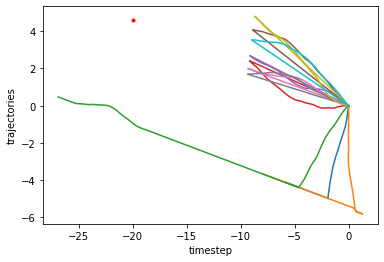

In [17]:
for i in range(len(positions)):
    plt.plot(pos[i][:,0], pos[i][:,2])
plt.plot([-356.02 - positions[0][0][0]], [50.6 - positions[0][0][2]], marker='o', markersize=3, color="red")
plt.xlabel('timestep')
plt.ylabel('trajectories')
plt.show()

In [ ]:
imgs = np.expand_dims(np.asarray(env_info.visual_observations)[0][0], axis=0)
input = np.transpose(imgs, (0, 3, 1, 2))
input = np.concatenate([input, input, input, input], 0)
print(input.shape)

m1  = torch.nn.Conv2d(3, 32, kernel_size=8, stride=4)
m2  = torch.nn.Conv2d(32, 64, kernel_size=4, stride=2)
m3  = torch.nn.Conv2d(64, 64, kernel_size=3, stride=1)
fc4 = torch.nn.Linear(34 * 34 * 64, 512)
fc5 = torch.nn.Linear(512, 9)

input = torch.randn(1, 3, 300, 300)
output1 = m1(input)
print(output1.shape)
output2 = m2(output1)
print(output2.shape)
output3 = torch.flatten(m3(output2))
print(output3.shape)
output4 = fc4(output3)
print(output4.shape)
output5 = fc5(output4)

# fc5(fc4(m3(m2(m1(input)))))


In [ ]:
input = torch.randn(3, 300, 300)
input = input.unsqueeze(0)

In [ ]:
input.shape

In [ ]:
output5

In [ ]:
plt.imshow(np.asarray(env_info.visual_observations)[0][0])

In [ ]:

# plot the scores
# fig = plt.figure()
# ax = fig.add_subplot(111)
# plt.plot(np.arange(len(scores)), scores)
# plt.ylabel('Score')
# plt.xlabel('Episode #')
# plt.show()

In [ ]:
print(agent.chck[1])

In [ ]:
agent.qnetwork_local(agent.chck[0].unsqueeze(0))

### Watch the agent running ( Using saved weights)

In [ ]:
# load the weights from file
agent.qnetwork_local.load_state_dict(torch.load(model_weight_name))

env_info = env.reset(train_mode=False)[brain_name] # reset the environment
state = env_info.vector_observations[0]            # get the current state
score = 0                                          # initialize the score

while True:
    action = agent.act(state)                      # select an action
    env_info = env.step(action)[brain_name]        # send the action to the environment
    next_state = env_info.vector_observations[0]   # get the next state
    reward = env_info.rewards[0]                   # get the reward
    done = env_info.local_done[0]                  # see if episode has finished
    score += reward                                # update the score
    state = next_state                             # roll over the state to next time step
    if done:                                       # exit loop if episode finished
        break
    
print("Score: {}".format(score))

### Close Unity ML Environment

In [ ]:
env.close()